<a href="https://colab.research.google.com/github/dookda/cmu_udfire_gee/blob/main/prediction_hotspot_lstm_predicted_for2025_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Initialize Earth Engine
ee.Authenticate()

# ตรวจสอบและเริ่มต้นการเชื่อมต่อ GEE
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

In [ ]:
fc = ee.FeatureCollection("projects/ee-sakda-451407/assets/fire/khunyoam");
mergedGeo = fc.geometry();
study_area = mergedGeo.bounds();

# Step 1: Define study area
# study_area = ee.Geometry.Polygon([
#     [
#         [100.3239626732374, 18.8300820494173],
#         [100.3239626732374, 18.335440374918317],
#         [101.10673855214365, 18.335440374918317],
#         [101.10673855214365, 18.8300820494173],
#         [100.3239626732374, 18.8300820494173],
#     ]
# ]);
# study_area = ee.FeatureCollection("projects/ee-sakda-451407/assets/fire/winagsa");

# print(study_area)

date_start = ee.Date('2020-01-01')
date_end = ee.Date('2024-12-31')

# Step 2: Load FIRMS VIIRS fire data
firms = ee.ImageCollection('FIRMS')\
    .select('confidence')\
    .filterDate(date_start, date_end)\
    .filterBounds(study_area)

# Step 3: Convert ImageCollection to FeatureCollection of fire points with confidence > 80
def create_fire_points(image):
    fire_mask = image.select('confidence').gt(80)\
        .set('system:time_start', image.get('system:time_start'))
    vectors = fire_mask.reduceToVectors(
        geometry=study_area,
        scale=375,
        geometryType='centroid',
        labelProperty='fire',
        maxPixels=1e9
    ).filterBounds(study_area)
    return vectors.map(lambda feature: feature.set('system:time_start', image.get('system:time_start')))

fire_points = firms.map(create_fire_points)
flattened_points = fire_points.flatten()

# Step 4: Function to count hotspots by week
def count_hotspots_by_week(fire_points, start_date, end_date):
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    weeks = ee.List.sequence(0, end.difference(start, 'week').floor())

    def count_week(week_offset):
        week_start = start.advance(week_offset, 'week')
        week_end = week_start.advance(1, 'week')
        weekly_points = fire_points.filterDate(week_start, week_end)
        count = weekly_points.size()
        return ee.Feature(None, {
            'week': week_start.format('YYYY-MM-dd'),
            'hotspot': count
        })

    return ee.FeatureCollection(weeks.map(count_week))

# Step 5: Generate weekly counts
weekly_hotspot_counts = count_hotspots_by_week(flattened_points, date_start, date_end)

# Step 6: Export weekly counts to a Pandas DataFrame
weekly_counts_list = weekly_hotspot_counts.getInfo()['features']
df = pd.DataFrame([{
    'week': f['properties']['week'],
    'hotspot': f['properties']['hotspot']
} for f in weekly_counts_list])

# Step 7: Process DataFrame for LSTM
df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week').sort_index()
df['hotspot'] = pd.to_numeric(df['hotspot'], errors='coerce').fillna(0)

In [ ]:

# Step 10: Create a Folium map
def add_ee_layer(ee_object, vis_params, name):
    try:
        if isinstance(ee_object, ee.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
        elif isinstance(ee_object, ee.Geometry):
            map_id_dict = ee.Feature(ee_object).getMapId(vis_params)
        elif isinstance(ee_object, ee.FeatureCollection):
            map_id_dict = ee.FeatureCollection(ee_object).getMapId(vis_params)
        folium.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name=name,
            overlay=True,
            control=True
        ).add_to(m)
    except Exception as e:
        print(f"Error adding {name} layer: {e}")

# Initialize Folium map
f = folium.Figure(height=400)
# m = folium.Map(location=map_center, zoom_start=12)
m = folium.Map(location=[18.6700, 100.5925], zoom_start=10).add_to(f)

folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

add_ee_layer(study_area, {'color': 'yellow'}, 'Thailand Boundary')
add_ee_layer(flattened_points, {'color': 'red'}, 'FIRMS Hotspots')
m.add_child(folium.LayerControl())

bnd = study_area.bounds().getInfo()
south_west = bnd['coordinates'][0][0]
north_east = bnd['coordinates'][0][2]

bounds = [south_west, north_east]
flipped = [pt[::-1] for pt in bounds]
print(flipped)
m.fit_bounds(flipped)
# m.save('thailand_hotspots.html')
m

[[18.592288762428556, 97.66686095875922], [19.09177049555895, 98.15871317869457]]


In [ ]:
# Extract hotspot data
hotspot = df['hotspot'].values

# Normalize data
scaler = MinMaxScaler()
hotspot_normalized = scaler.fit_transform(hotspot.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# define sequence length
sequence_length = 25
X, y = create_sequences(hotspot_normalized, sequence_length)

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation="relu", return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 25, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model type 1
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ฝึกโมเดล
history = model.fit(
      X_train, y_train,
      epochs=100,
      batch_size=16,
      validation_split=0.2,
      verbose=0,
      callbacks=[early_stopping]
    )

In [ ]:
# Model type 2
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

In [ ]:
# Model type 4
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=0
)

In [ ]:
# Model type 7
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, 1)))
model.add(LSTM(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


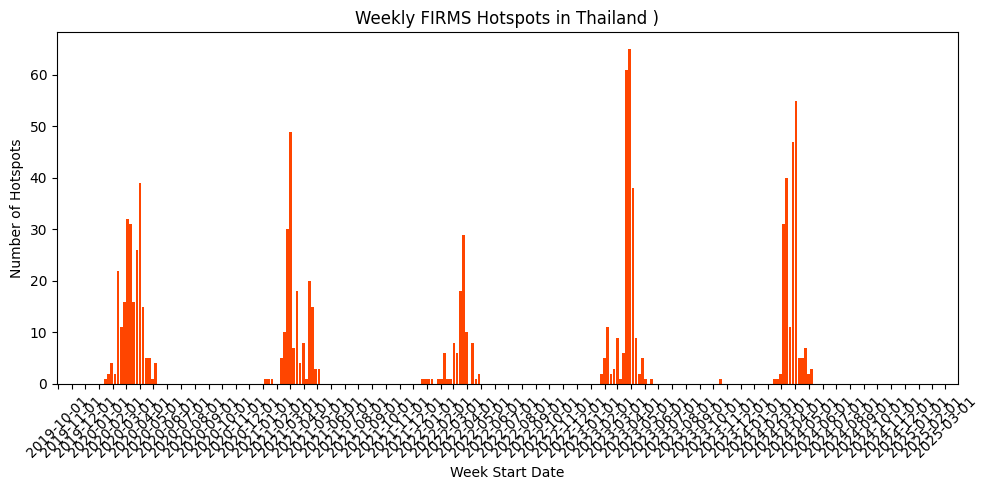

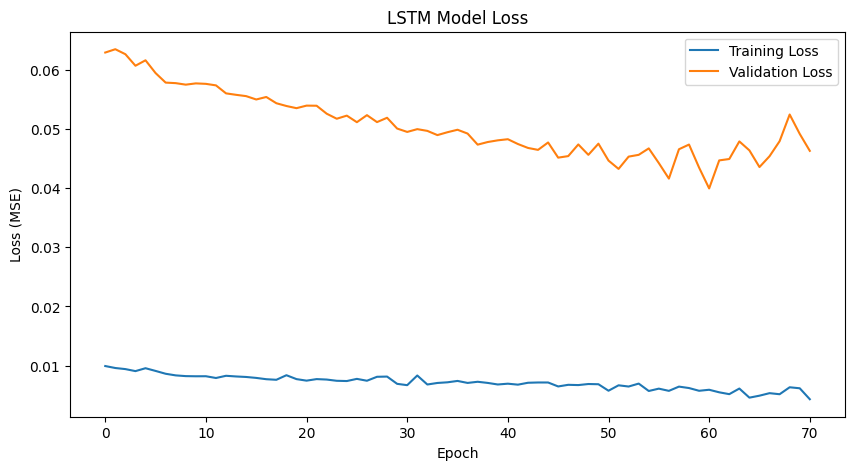

In [ ]:
# Step 11: Create a Matplotlib chart for 2024 data
plt.figure(figsize=(10, 5))
plt.bar(df.index, df['hotspot'], width=6, color='#ff4500', align='center')
plt.title('Weekly FIRMS Hotspots in Thailand )')
plt.xlabel('Week Start Date')
plt.ylabel('Number of Hotspots')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('weekly_hotspot_counts_2024.png')
plt.show()

# Step 12: Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
# plt.savefig('lstm_training_loss.png')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Mean Squared Error (MSE): 67.79
Mean Absolute Error (MAE): 2.96
R-squared (R2): 0.35


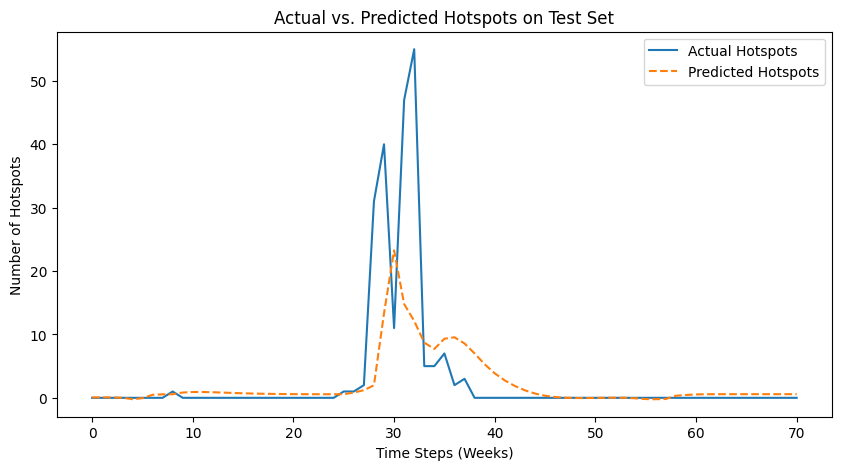

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_normalized = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred_normalized)
y_actual = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_actual, label='Actual Hotspots')
plt.plot(y_pred, label='Predicted Hotspots', linestyle="--")
plt.title('Actual vs. Predicted Hotspots on Test Set')
plt.xlabel('Time Steps (Weeks)')
plt.ylabel('Number of Hotspots')
plt.legend()
plt.show()

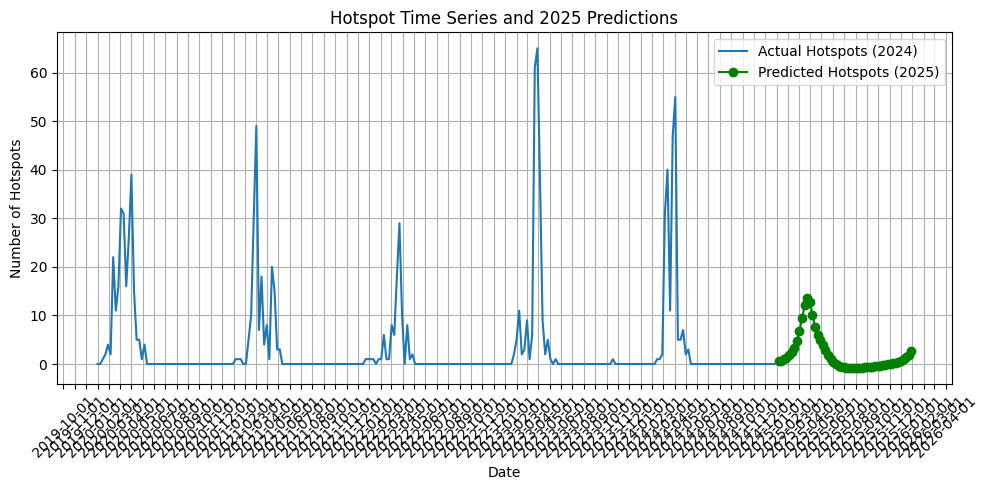

Total Number of FIRMS Hotspots in Study area (2020 - 2024): 936
Total Predicted Number of Hotspots in Thailand (2025): 52


In [ ]:
# Step 9: Predict hotspots for 2025 (52 weeks)
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=53, freq='W-MON')[1:]  # 52 weeks starting from the next Monday

# Prepare the last sequence for prediction
current_sequence = hotspot_normalized[-sequence_length:].reshape(1, sequence_length, 1)
future_predictions_scaled = []

# Predict for 52 weeks
for _ in range(52):
    predicted_scaled_next = model.predict(current_sequence, verbose=0)
    future_predictions_scaled.append(predicted_scaled_next[0][0])
    current_sequence = np.append(current_sequence[:, 1:, :], predicted_scaled_next.reshape(1, 1, 1), axis=1)

# Denormalize predictions
predicted_hotspots_2025 = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

# Print predictions
# print("\nPredicted Weekly Hotspot Counts for 2025:")
# for date, hotspot_count in zip(future_dates, predicted_hotspots_2025):
#     print(f"{date.strftime('%Y-%m-%d')}: {hotspot_count:.2f} hotspots")


# Step 13: Plot actual and predicted hotspots for 2025
actual_series = pd.Series(scaler.inverse_transform(hotspot_normalized).flatten(), index=df.index)
predicted_series_2025 = pd.Series(predicted_hotspots_2025, index=future_dates)
combined_series = pd.concat([actual_series, predicted_series_2025])

plt.figure(figsize=(10, 5))
plt.plot(actual_series.index, actual_series.values, label='Actual Hotspots (2024)')
plt.plot(predicted_series_2025.index, predicted_series_2025.values, 'go-', label='Predicted Hotspots (2025)')
plt.xlabel('Date')
plt.ylabel('Number of Hotspots')
plt.title('Hotspot Time Series and 2025 Predictions')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('hotspot_predictions_2025.png')
plt.show()

# Step 14: Print total hotspot count for 2024
total_count = flattened_points.size().getInfo()
print(f"Total Number of FIRMS Hotspots in Study area ({date_start.get('year').getInfo()} - {date_end.get('year').getInfo()}): {total_count}")
# Step 15: Print total hotspot count for 2025
total_count_2025 = len(predicted_hotspots_2025)
print(f'Total Predicted Number of Hotspots in Thailand (2025): {total_count_2025}')